In [299]:
# from category_class import Category
from product_class import Product

import numpy as np
from scipy import stats
import datetime
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from workalendar.usa import UnitedStates
from operator import itemgetter
import pandas as pd
from math import pi

In [349]:
products1 = list(np.load('office_products_sorted_ph.npy', allow_pickle=True))
products2 = list(np.load('software.npy', allow_pickle=True))
products3 = list(np.load('product_electronics_sorted_ph.npy', allow_pickle=True))
products4 = list(np.load('toy_products_sorted_ph.npy', allow_pickle=True))

products1 = [Product(i) for i in products1]
products2 = [Product(i) for i in products2]
products3 = [Product(i) for i in products3]
products4 = [Product(i) for i in products4]

Rating and Review data not available
Rating and Review data not available
Rating and Review data not available
Rating and Review data not available
Rating and Review data not available
Rating and Review data not available
Rating and Review data not available
Rating and Review data not available
Rating and Review data not available
Rating and Review data not available


In [345]:
class Category:
    '''
        Represent a list of products in a given category
    '''

    def __init__(self, product_list):
        assert isinstance(product_list, (list, Product))
        if isinstance(product_list, list):
            assert all(isinstance(i, Product) for i in product_list)

        self.product_list = product_list
        self.num_sales, self.percent_sale = self.calculate_avg_num_sales()
        self.sale_decrease_percentage = self.calculate_avg_sale_perc()

    def calculate_avg_num_sales(self):
        '''Calculate number of sales for products in category
        
        :return: the average number and percentage of sale of the category
        :rtype: int, float
        '''
        # TODO: Add year as input

        num = list()
        percents = list()
        for i in range(len(self.product_list)):
            sale, time, number, pct, decrease = Product.saleDetector(self.product_list[i])
            num.append(number)
            percents.append(pct)
                  
        res_num = sum(num)/len(num)
        res_percent = sum(percents)/len(percents)
        
        return res_num, res_percent
        

    def calculate_avg_sale_perc(self):
        '''Calculate avg sale percentage for products in category
        
        :return: the avg sale percentage(e.g. X% off)
        :rtype: float
        '''
        # TODO: Add year as input

        decrese_list = list()
        for i in range(len(self.product_list)):
            sale, time, number, pct, decrease = Product.saleDetector(self.product_list[i])
            if decrease != 0:
                decrese_list.append(decrease)
        
        return sum(decrese_list)/len(decrese_list)
        

    def price_variation(self):
        '''Calculate price variation using standardized price values
        
        :return: a list of price variation on standarized price values
        :rtype: list 
        '''
        price_variation_list = list()
        for p in self.product_list:
            price_variation_list.append(p.df.standardized.diff().fillna(0))
        return price_variation_list 

    def feature_correlation(self, feature_1, feature_2):
        '''Generate a plot for the category, showing the correlation between two features
        
        :param feature_1: [description]
        :type feature_1: [type]
        :param feature_2: [description]
        :type feature_2: [type]
        '''
        assert isinstance(feature_1, str)
        assert isinstance(feature_2, str)
        
        x = [getattr(product, feature_1) for product in self.product_list]
        y = [getattr(product, feature_2) for product in self.product_list]

        assert len(x) == len(y)

        plt.scatter(x,y)

        
        
    def holiday_correlation(self, year=2018, plot=False):
        '''Plot standardized avg price history correlation with a country's holidays

        :param year: Year for which prices are to be plotted 
        :type year: int
        :param plot: Indicates whether to plot the data or not 
        :type plot: bool
        :return: List of dates for which prices are available and their corresponding prices
        :rtype: list
        '''
        top_hols = ['New year', 'Independence Day', 'Thanksgiving Day', 'Christmas Day']
        cal = UnitedStates()
        top_hols_dates = [hol[0] for hol in cal.holidays(year) if hol[1] in top_hols]

        holiday_df = self.product_list[0].price_holiday_correlation(year)
        for i, product in enumerate(self.product_list[1:]):
            sufix = ("_%d" % i, "_%d" % (i+1))
            holiday_df = pd.merge_ordered(holiday_df, product.price_holiday_correlation(), on='amazon_time', suffixes = sufix)
        
        holiday_df = holiday_df.loc[holiday_df['amazon_time'].isin(top_hols_dates)]
        holiday_avg = holiday_df.mean(1)
        holiday_avg.index = top_hols
        if plot:
            self.plot_radar(holiday_avg)
        
        return holiday_df, holiday_avg
    
    def time_price(self, year=2018, plot=False):
        standard_df = self.product_list[0].df[['amazon_time', 'standardized']][self.product_list[0].df['amazon_time'].dt.year == year]
        for i, product in enumerate(self.product_list[1:]):
            suffix = ("_%d" % i, "_%d" % (i+1))
            standard_df = pd.merge_ordered(standard_df, product.df[['amazon_time', 'standardized']][product.df['amazon_time'].dt.year == year], on='amazon_time', suffixes=suffix)
        standard_df = standard_df.set_index(['amazon_time'])
        standard_df = standard_df.mean(1)
        return standard_df

In [468]:
def plot_time_price(data):
    colors = ['b', 'y', 'g', 'r']
    fig, axes = plt.subplots(figsize=(17, 14), nrows=2, ncols=2)
    fig.subplots_adjust(wspace=0.2, hspace=0.20, top=0.85, bottom=0.05)
    locator = mdates.MonthLocator(interval=3)
    formatter = mdates.DateFormatter('%b')
    
    cal=UnitedStates()
    #Goal: add annotations to the following four holidays: ['New year', 'Independence Day', 'Thanksgiving Day', 'Christmas Day']
    ann_labels = ['New year', 'Independence Day', 'Thanksgiving Day', 'Christmas Day']
    top_hols_dates = [hol[0] for hol in cal.holidays(data.index[0].year) if hol[1] in ann_labels] #Holidays as date_time objects
    
    xy_loc = [[(0,-70), (0,100), (-100,-70), (-50,80)], [(0,-70), (0,70), (-50,-70), (0,-70)], [(0,-70), (0,70), (-50,-70), (0,-70)], [(0,-70), (0,70), (-50,-70), (0,-70)]]
    
    for ax, data_item, color, xy_loc_1 in zip(axes.flat, data.items(), colors, xy_loc):
        title = data_item[0]
        d = data_item[1]
        
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        
        ax.plot(d.index, d.values, color = color)
        ax.plot(d.index, np.zeros(len(d.index)), color='grey')
        ax.set_title(title,weight='bold', size=20, position=(0.5, 1.03), color = color,  
                     horizontalalignment='center', verticalalignment='center')
        
        ax.set_yticks(np.arange(-0.5,0.6,0.1))
    
        for hol, hol_date, xy_loc_2 in zip(ann_labels, top_hols_dates, xy_loc_1):
            if title == 'Office Products':
                ax.annotate(hol,
                    xy=(hol_date, d.loc[hol_date]), xycoords='data',
                    xytext=xy_loc_2, textcoords='offset points',
                    size=20,
                    arrowprops=dict(arrowstyle="->"))
#                     bbox=dict(boxstyle="round",
#                             fc=(1.0, 0.7, 0.7),
#                             ec=(1., .5, .5)),
#                     arrowprops=dict(arrowstyle="wedge,tail_width=1.",
#                                 fc=(1.0, 0.7, 0.7), ec=(1., .5, .5),
#                                 relpos=(0.2, 0.8),
#                                 connectionstyle="arc3,rad=-0.1"))
                      
            else:
                ax.annotate('',
                    xy=(hol_date, d.loc[hol_date]), xycoords='data',
                    xytext=(-50, 30), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->"))
    plt.savefig('test1.jpg')

In [350]:
cat1 = Category(products1)
cat2 = Category(products2)
cat3 = Category(products3)
cat4 = Category(products4)

In [351]:
# _, hol_1 = cat1.holiday_correlation(2018, False)
# _, hol_2 = cat2.holiday_correlation(2018, False)
# _, hol_3 = cat3.holiday_correlation(2018, False)

time_price_1 = cat1.time_price(2018, False)
time_price_2 = cat2.time_price(2018, False)
time_price_3 = cat3.time_price(2018, False)
time_price_4 = cat4.time_price(2018, False)

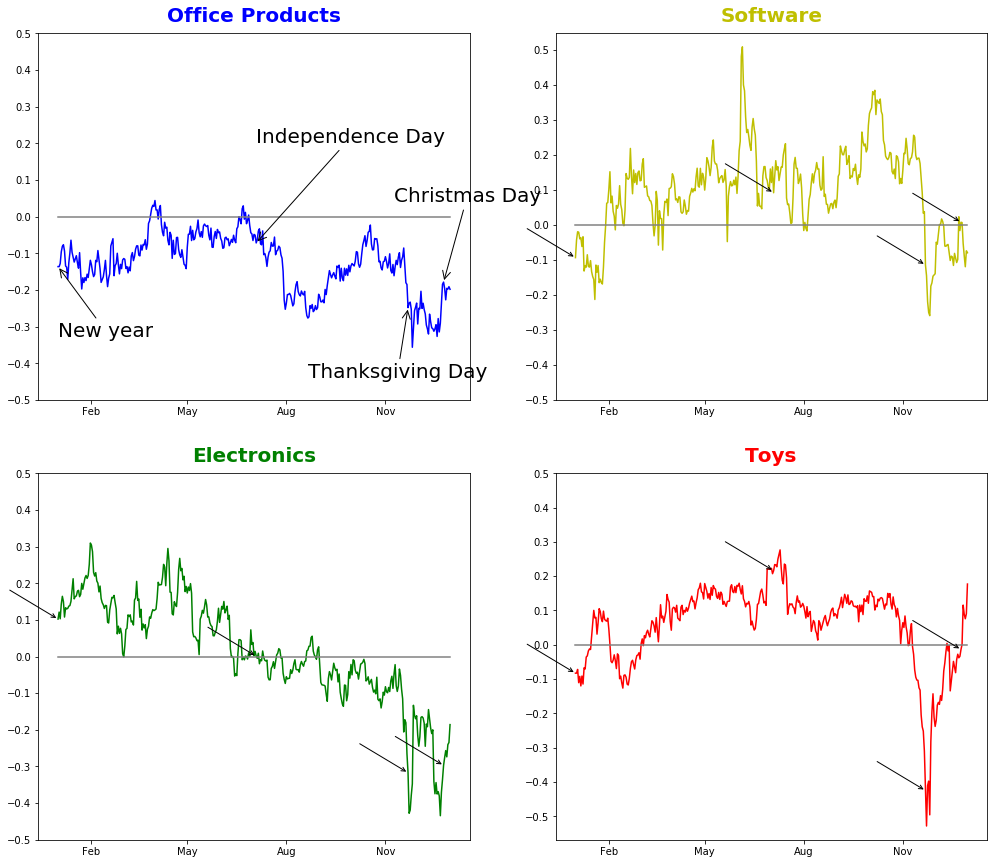

In [469]:
frame = {'Office Products': time_price_1, 'Software': time_price_2, 'Electronics': time_price_3, 'Toys': time_price_4}
time_price_df = pd.DataFrame(frame)
plot_time_price(data = time_price_df)

In [383]:
frame = {'Office Products': hol_1, 'Software': hol_2, 'Electronics': hol_3, 'Toys': hol_3}
hol_df = pd.DataFrame(frame)
plot_time_price(data = hol_df)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1a1a1a0c80> (for post_execute):


ValueError: view limit minimum -0.15000000000000002 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -0.15000000000000002 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [148]:
from math import pi
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
# number of variable
# categories=list(df)[1:]
categories = ['New year', 'Independence Day', 'Thanksgiving', 'Christmas', 'A']
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
print(angles)
 
# Initialise the spider plot
# ax = plt.subplot(111, polar=True)
ax = plt(polar=True)

# plt.figure(figsize=(9,9))

temp = [0.0, 1.2566370614359172, 2.5132741228718345, 3.7699111843077517, 5.026548245743669, 0.0]
# Draw one axe per variable + add labels labels yet
# trans, _ , _ = ax.get_xaxis_text1_transform([30, 20, 30, 40, 60])
plt.xticks(temp, categories, color='black', size=12, fontfamily='serif', wrap=True)
ax.xaxis.pickradius = 40
 
# Draw ylabels
ax.set_rlabel_position(-30)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=9)
plt.ylim(0,40)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)
plt.savefig('test.jpg')

[0.0, 1.2566370614359172, 2.5132741228718345, 3.7699111843077517, 5.026548245743669, 0.0]


AttributeError: module 'matplotlib.pyplot' has no attribute 'pyplot'